### 1. Import modules

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import re
import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler

In [2]:
# True on 'instances' means sample 10% of the data, to speed up the script
TEST_instances = False

# True on 'iterations' means run the script for (only) 3 iterations instead of 10
TEST_iterations = False

### 2. Merge .pkl's

In [3]:
# zuigelingen
zuigelingen = pd.read_pickle('4_Data\Pickles\zuigelingen.pkl')

In [4]:
# Replace all types of whitespace characters with an underscore and delete all special characters
zuigelingen.columns = zuigelingen.columns.str.replace(r'\s+', '_', regex=True)
zuigelingen.columns = zuigelingen.columns.str.replace(r'\W+', '', regex=True)

In [5]:
for column in zuigelingen.columns:
    print(f'\'{column}\',')

'Clientnummer',
'BMR',
'DKTP',
'DTP',
'Hib',
'Pneu',
'Excluded',
'Hepatitis_B',
'MenACWYMenC',
'Geboortejaarmaand',
'Tweeling',
'GeboortejaarmaandBiologischeMoeder',
'LeeftijdBiologischeMoederBijGeboorte',
'Geslacht',
'Geboorteland',
'Huisnummer_BRP',
'Postcode6_BRP',
'ID',
'Postcodes',
'PC6',
'BuurtCode',
'Buurtnaam',
'PC4',
'Zuigelingen_status_BMR',
'Zuigelingen_status_Pneu',
'Zuigelingen_status_DKTP',
'Zuigelingen_status_MenACWYMenC',
'Zuigelingen_status_Hib',
'Zuigelingen_status_Hepatitis_B',
'Zuigelingen_status',
'Toestemming',
'aantal_inwoners',
'aantal_mannen',
'aantal_vrouwen',
'aantal_inwoners_0_tot_15_jaar',
'aantal_inwoners_15_tot_25_jaar',
'aantal_inwoners_25_tot_45_jaar',
'aantal_inwoners_45_tot_65_jaar',
'aantal_inwoners_65_jaar_en_ouder',
'percentage_geb_nederland_herkomst_nederland',
'percentage_geb_nederland_herkomst_overig_europa',
'percentage_geb_nederland_herkomst_buiten_europa',
'percentage_geb_buiten_nederland_herkomst_europa',
'percentage_geb_buiten_nederland_her

In [6]:
# # Loop over every column name in a df
# def column_cleaner(df):
#     for column in df.columns:
#         ## Remove categories
#         # Get position of last capital letter by iterating backwards
#         pos = 0
#         for i in range(len(column)-1, 0, -1):
#             if column[i].isupper() and (column[i-1].islower() or column[i-1] == '_'):
#                 pos = i
#                 break
#         # If there is a capital letter
#         if pos != 0 and column[-1] != '_':
#             # Remove everything after the before capital letter
#             df.rename(columns={column: column[pos:]}, inplace=True)
#         elif pos != 0 and column[-1] == '_':
#             df.rename(columns={column: column[pos:] + '%'}, inplace=True)
#     return df

# # Manually set some other column names
# def column_editor(df):
#     df.rename(columns={'Inkomen_van_huishoudens40_huishoudens_met_laagste_inkomen_%': 'Huishoudens_laagste_landelijke_40%_huishoudensinkomens_%'}, inplace=True)
#     df.rename(columns={'Inkomen_van_huishoudens20_huishoudens_met_hoogste_inkomen_%': 'Huishoudens_hoogste_landelijke_20%_huishoudensinkomens_%'}, inplace=True)
#     df.rename(columns={'Huishoudens_tot_110_van_sociaal_minimum_%': 'Huishoudens_tot_110%_van_sociaal_minimum_%'}, inplace=True)
#     df.rename(columns={'Huishoudens_tot_120_van_sociaal_minimum_%': 'Huishoudens_tot_120%_van_sociaal_minimum_%'}, inplace=True)
#     df.rename(columns={'Personenautos_per_huishouden_per_huishouden': 'Personenautos_per_huishouden'}, inplace=True)
#     df.rename(columns={'stedelijkheid_1.0': 'zeer_sterk_stedelijk'}, inplace=True)
#     df.rename(columns={'stedelijkheid_2.0': 'sterk_stedelijk'}, inplace=True)
#     df.rename(columns={'stedelijkheid_3.0': 'matig_stedelijk'}, inplace=True)
#     df.rename(columns={'stedelijkheid_4.0': 'weinig_stedelijk'}, inplace=True)
#     df.rename(columns={'stedelijkheid_5.0': 'niet_stedelijk'}, inplace=True)
#     return df

# overzicht = zuigelingen.copy()
# overzicht = column_cleaner(overzicht)
# overzicht = column_editor(overzicht)
# overzicht = pd.DataFrame(overzicht.isna().mean().round(2), columns=['Proporties ontbrekende waarden'])
# overzicht.to_csv('zuigelingen_overzicht.csv')

### 3. Engineer features

#### 3.1 Continuous numerical

##### 3.1.1 Direct features

In [7]:
# Get columns that need no further transformation
X_zuigelingen_numericals = zuigelingen[[
        # 'Clientnummer',                               # Useless
        # 'Geboortejaarmaand',                          # We construct age from this
        # 'Tweeling',                                   # Boolean
        # 'Buurt_BRP',                                  # Useless
        # 'CBS_Buurtcode_BRP',                          # Useless
        # 'GeboortejaarmaandBiologischeMoeder',         # We construct age from this
        # 'LeeftijdBiologischeMoederBijGeboorte',       # We construct age from this
        # 'Geslacht',                                   # Boolean
        # 'Geboorteland',                               # Categorical
        # 'Postcode6_BRP',                              # Useless
        # 'Postcode4_BRP',                              # Useless
        # 'Huisnummer_BRP',                             # Useless
        'BMR',                                        # Drop after missing value imputation
        'DKTP',                                       # Drop after missing value imputation
        'DTP',                                        # Drop after missing value imputation
        'Hib',                                        # Drop after missing value imputation
        'Pneu',                                       # Drop after missing value imputation
        'Excluded',                                   # Drop after missing value imputation
        'Hepatitis_B',                                # Drop after missing value imputation
        'MenACWYMenC',                                # Drop after missing value imputation
        # 'Zuigelingen_status_BMR',                     # Related to target feature
        # 'Zuigelingen_status_Pneu',                    # Related to target feature
        # 'Zuigelingen_status_DKTP',                    # Related to target feature
        # 'Zuigelingen_status_MenACWYMenC',             # Related to target feature
        # 'Zuigelingen_status_Hib',                     # Related to target feature
        # 'Zuigelingen_status_Hepatitis_B',             # Related to target feature
        # 'Zuigelingen_status',                         # Related to target feature
        # 'Toestemming',                                # Boolean
        'aantal_inwoners',
        'aantal_mannen',
        'aantal_vrouwen',
        'aantal_inwoners_0_tot_15_jaar',
        'aantal_inwoners_15_tot_25_jaar',
        'aantal_inwoners_25_tot_45_jaar',
        'aantal_inwoners_45_tot_65_jaar',
        # 'aantal_inwoners_65_jaar_en_ouder',           # nth column in category
        # 'percentage_geb_nederland_herkomst_nederland',                # Ordinal
        # 'percentage_geb_nederland_herkomst_overig_europa',            # Ordinal
        # 'percentage_geb_nederland_herkomst_buiten_europa',            # Ordinal
        # 'percentage_geb_buiten_nederland_herkomst_europa',            # Ordinal
        # 'percentage_geb_buiten_nederland_herkmst_buiten_europa',      # Ordinal
        'aantal_part_huishoudens',
        'aantal_eenpersoonshuishoudens',
        'aantal_meerpersoonshuishoudens_zonder_kind',
        'aantal_eenouderhuishoudens',
        'aantal_tweeouderhuishoudens',
        # 'gemiddelde_huishoudensgrootte',              # nth column in category
        'aantal_woningen',
        # 'aantal_woningen_bouwjaar_voor_1945',         # Deemed insignificant
        # 'aantal_woningen_bouwjaar_45_tot_65',         # Deemed insignificant
        # 'aantal_woningen_bouwjaar_65_tot_75',         # Deemed insignificant
        # 'aantal_woningen_bouwjaar_75_tot_85',         # Deemed insignificant
        # 'aantal_woningen_bouwjaar_85_tot_95',         # Deemed insignificant
        # 'aantal_woningen_bouwjaar_95_tot_05',         # Deemed insignificant
        # 'aantal_woningen_bouwjaar_05_tot_15',         # Deemed insignificant
        # 'aantal_woningen_bouwjaar_15_en_later',       # Deemed insignificant
        'aantal_meergezins_woningen',
        # 'percentage_koopwoningen',                    # nth column in category
        # 'percentage_huurwoningen',                    # Ordinal
        'aantal_huurwoningen_in_bezit_woningcorporaties',
        'aantal_niet_bewoonde_woningen',
        'gemiddelde_woz_waarde_woning',
        'aantal_personen_met_uitkering_onder_aowlft',
        # 'omgevingsadressendichtheid',                 # Deemed insignificant
        # 'stedelijkheid',                              # Ordinal
        'BevolkingAantal_inwoners_aantal',
        'BevolkingBurgerlijke_staatGehuwd_aantal',
        'BevolkingBurgerlijke_staatGescheiden_aantal',
        'BevolkingPersonen_met_een_migratieachtergrondNietwestersMarokko_aantal',
        'BevolkingPersonen_met_een_migratieachtergrondNietwestersNederlandse_Antillen_en_Aruba_aantal',
        'BevolkingPersonen_met_een_migratieachtergrondNietwestersSuriname_aantal',
        'BevolkingPersonen_met_een_migratieachtergrondNietwestersTurkije_aantal',
        'BevolkingPersonen_met_een_migratieachtergrondNietwestersOverig_nietwesters_aantal',
        'OpleidingsniveauOpleidingsniveau_laag_aantal',
        'OpleidingsniveauOpleidingsniveau_hoog_aantal',
        'ArbeidNettoarbeidsparticipatie_',
        'InkomenInkomen_van_personenGemiddeld_inkomen_per_inkomensontvanger_x_1_000_euro',
        'InkomenInkomen_van_personenGemiddeld_inkomen_per_inwoner_x_1_000_euro',
        # 'InkomenInkomen_van_personen40_personen_met_laagste_inkomen_',    # Deemed insignificant
        # 'InkomenInkomen_van_personen20_personen_met_hoogste_inkomen_',    # Deemed insignificant
        'InkomenInkomen_van_huishoudensGem_gestandaardiseerd_inkomen_van_huish_x_1_000_euro',
        'InkomenInkomen_van_huishoudens40_huishoudens_met_laagste_inkomen_',
        'InkomenInkomen_van_huishoudens20_huishoudens_met_hoogste_inkomen_',
        'InkomenInkomen_van_huishoudensHuishoudens_met_een_laag_inkomen_',
        'InkomenInkomen_van_huishoudensHuish_onder_of_rond_sociaal_minimum_',
        'InkomenInkomen_van_huishoudensHuishoudens_tot_110_van_sociaal_minimum_',
        'InkomenInkomen_van_huishoudensHuishoudens_tot_120_van_sociaal_minimum_',
        'InkomenInkomen_van_huishoudensMediaan_vermogen_van_particuliere_huish_x_1_000_euro',
        'Sociale_zekerheidPersonen_per_soort_uitkering_Bijstand_aantal',
        'Sociale_zekerheidPersonen_per_soort_uitkering_AO_aantal',
        'Sociale_zekerheidPersonen_per_soort_uitkering_WW_aantal',
        'Sociale_zekerheidPersonen_per_soort_uitkering_AOW_aantal',
        'ZorgJongeren_met_jeugdzorg_in_natura_aantal',
        'ZorgPercentage_jongeren_met_jeugdzorg_',
        'MotorvoertuigenPersonenautosPersonenautos_per_huishouden_per_huishouden',
        'Siblings',
        # 'Geboortejaarmaand_relatie_ouder1',               # We construct age from this
        # 'Geboorteland_relatie_ouder1',                    # Categorical
        # 'Geslacht_relatie_ouder1',                        # Boolean
        # 'Geboortejaarmaand_relatie_ouder2',               # We construct age from this
        # 'Geboorteland_relatie_ouder2',                    # Categorical
        # 'Geslacht_relatie_ouder2',                        # Boolean
        # 'Gevaccineerd_ouder1',                            # Boolean
        # 'Gevaccineerd_ouder2',                            # Boolean
        # 'Geboorteland_cat',                               # Categorical
        # 'Geboorteland_relatie_ouder1_cat',                # Categorical
        # 'Geboorteland_relatie_ouder2_cat',                # Categorical
        # 'Geboorteland_cat3',                              # Categorical
        # 'Geboorteland_relatie_ouder1_cat3',               # Categorical
        # 'Geboorteland_relatie_ouder2_cat3',               # Categorical
        # 'CBS_indeling'                                    # Categorical     
        ]]

In [8]:
# Convert all columns that are of dtype object to float64, if error proceed with next column
for col in X_zuigelingen_numericals.columns:
    if X_zuigelingen_numericals[col].dtype == 'object':
        try:
            X_zuigelingen_numericals[col] = X_zuigelingen_numericals[col].str.replace(',', '.').astype('float64')
        except:
            continue

In [9]:
# Transform absolute numbers to relative numbers
X_zuigelingen_numericals['aandeel_mannen'] = X_zuigelingen_numericals['aantal_mannen'] / X_zuigelingen_numericals['aantal_inwoners']
X_zuigelingen_numericals['aandeel_vrouwen'] = X_zuigelingen_numericals['aantal_vrouwen'] / X_zuigelingen_numericals['aantal_inwoners']
X_zuigelingen_numericals['aandeel_inwoners_0_tot_15_jaar'] = X_zuigelingen_numericals['aantal_inwoners_0_tot_15_jaar'] / X_zuigelingen_numericals['aantal_inwoners']
X_zuigelingen_numericals['aandeel_inwoners_15_tot_25_jaar'] = X_zuigelingen_numericals['aantal_inwoners_15_tot_25_jaar'] / X_zuigelingen_numericals['aantal_inwoners']
X_zuigelingen_numericals['aandeel_inwoners_25_tot_45_jaar'] = X_zuigelingen_numericals['aantal_inwoners_25_tot_45_jaar'] / X_zuigelingen_numericals['aantal_inwoners']
X_zuigelingen_numericals['aandeel_inwoners_45_tot_65_jaar'] = X_zuigelingen_numericals['aantal_inwoners_45_tot_65_jaar'] / X_zuigelingen_numericals['aantal_inwoners']
# X_zuigelingen_numericals['aandeel_inwoners_65_jaar_en_ouder'] = X_zuigelingen_numericals['aantal_inwoners_65_jaar_en_ouder'] / X_zuigelingen_numericals['aantal_inwoners']

X_zuigelingen_numericals['BevolkingBurgerlijke_staatGehuwd_aandeel'] = X_zuigelingen_numericals['BevolkingBurgerlijke_staatGehuwd_aantal'] / X_zuigelingen_numericals['BevolkingAantal_inwoners_aantal']
X_zuigelingen_numericals['BevolkingBurgerlijke_staatGescheiden_aandeel'] = X_zuigelingen_numericals['BevolkingBurgerlijke_staatGescheiden_aantal'] / X_zuigelingen_numericals['BevolkingAantal_inwoners_aantal']
X_zuigelingen_numericals['BevolkingPersonen_met_een_migratieachtergrondNietwestersMarokko_aandeel'] = X_zuigelingen_numericals['BevolkingPersonen_met_een_migratieachtergrondNietwestersMarokko_aantal'] / X_zuigelingen_numericals['BevolkingAantal_inwoners_aantal']
X_zuigelingen_numericals['BevolkingPersonen_met_een_migratieachtergrondNietwestersNederlandse_Antillen_en_Aruba_aandeel'] = X_zuigelingen_numericals['BevolkingPersonen_met_een_migratieachtergrondNietwestersNederlandse_Antillen_en_Aruba_aantal'] / X_zuigelingen_numericals['BevolkingAantal_inwoners_aantal']
X_zuigelingen_numericals['BevolkingPersonen_met_een_migratieachtergrondNietwestersSuriname_aandeel'] = X_zuigelingen_numericals['BevolkingPersonen_met_een_migratieachtergrondNietwestersSuriname_aantal'] / X_zuigelingen_numericals['BevolkingAantal_inwoners_aantal']
X_zuigelingen_numericals['BevolkingPersonen_met_een_migratieachtergrondNietwestersTurkije_aandeel'] = X_zuigelingen_numericals['BevolkingPersonen_met_een_migratieachtergrondNietwestersTurkije_aantal'] / X_zuigelingen_numericals['BevolkingAantal_inwoners_aantal']
X_zuigelingen_numericals['BevolkingPersonen_met_een_migratieachtergrondNietwestersOverig_nietwesters_aandeel'] = X_zuigelingen_numericals['BevolkingPersonen_met_een_migratieachtergrondNietwestersOverig_nietwesters_aantal'] / X_zuigelingen_numericals['BevolkingAantal_inwoners_aantal']
X_zuigelingen_numericals['OpleidingsniveauOpleidingsniveau_laag_aandeel'] = X_zuigelingen_numericals['OpleidingsniveauOpleidingsniveau_laag_aantal'] / X_zuigelingen_numericals['BevolkingAantal_inwoners_aantal']
X_zuigelingen_numericals['OpleidingsniveauOpleidingsniveau_hoog_aandeel'] = X_zuigelingen_numericals['OpleidingsniveauOpleidingsniveau_hoog_aantal'] / X_zuigelingen_numericals['BevolkingAantal_inwoners_aantal']
X_zuigelingen_numericals['Sociale_zekerheidPersonen_per_soort_uitkering_Bijstand_aandeel'] = X_zuigelingen_numericals['Sociale_zekerheidPersonen_per_soort_uitkering_Bijstand_aantal'] / X_zuigelingen_numericals['BevolkingAantal_inwoners_aantal']
X_zuigelingen_numericals['Sociale_zekerheidPersonen_per_soort_uitkering_AO_aandeel'] = X_zuigelingen_numericals['Sociale_zekerheidPersonen_per_soort_uitkering_AO_aantal'] / X_zuigelingen_numericals['BevolkingAantal_inwoners_aantal']
X_zuigelingen_numericals['Sociale_zekerheidPersonen_per_soort_uitkering_WW_aandeel'] = X_zuigelingen_numericals['Sociale_zekerheidPersonen_per_soort_uitkering_WW_aantal'] / X_zuigelingen_numericals['BevolkingAantal_inwoners_aantal']
X_zuigelingen_numericals['Sociale_zekerheidPersonen_per_soort_uitkering_AOW_aandeel'] = X_zuigelingen_numericals['Sociale_zekerheidPersonen_per_soort_uitkering_AOW_aantal'] / X_zuigelingen_numericals['BevolkingAantal_inwoners_aantal']
X_zuigelingen_numericals['ZorgJongeren_met_jeugdzorg_in_natura_aandeel'] = X_zuigelingen_numericals['ZorgJongeren_met_jeugdzorg_in_natura_aantal'] / X_zuigelingen_numericals['BevolkingAantal_inwoners_aantal']

X_zuigelingen_numericals['aandeel_eenpersoonshuishoudens'] = X_zuigelingen_numericals['aantal_eenpersoonshuishoudens'] / X_zuigelingen_numericals['aantal_part_huishoudens']
X_zuigelingen_numericals['aandeel_meerpersoonshuishoudens_zonder_kind'] = X_zuigelingen_numericals['aantal_meerpersoonshuishoudens_zonder_kind'] / X_zuigelingen_numericals['aantal_part_huishoudens']
X_zuigelingen_numericals['aandeel_eenouderhuishoudens'] = X_zuigelingen_numericals['aantal_eenouderhuishoudens'] / X_zuigelingen_numericals['aantal_part_huishoudens']
X_zuigelingen_numericals['aandeel_tweeouderhuishoudens'] = X_zuigelingen_numericals['aantal_tweeouderhuishoudens'] / X_zuigelingen_numericals['aantal_part_huishoudens']

X_zuigelingen_numericals['aandeel_personen_met_uitkering_onder_aowlft'] = X_zuigelingen_numericals['aantal_personen_met_uitkering_onder_aowlft'] / X_zuigelingen_numericals['aantal_inwoners']

X_zuigelingen_numericals['aandeel_meergezins_woningen'] = X_zuigelingen_numericals['aantal_meergezins_woningen'] / X_zuigelingen_numericals['aantal_woningen']
X_zuigelingen_numericals['aandeel_huurwoningen_in_bezit_woningcorporaties'] = X_zuigelingen_numericals['aantal_huurwoningen_in_bezit_woningcorporaties'] / X_zuigelingen_numericals['aantal_woningen']
X_zuigelingen_numericals['aandeel_niet_bewoonde_woningen'] = X_zuigelingen_numericals['aantal_niet_bewoonde_woningen'] / X_zuigelingen_numericals['aantal_woningen']

# Drop all columns that are not needed anymore
X_zuigelingen_numericals = X_zuigelingen_numericals.drop(columns=['aantal_mannen',
                                            'aantal_vrouwen',
                                            'aantal_inwoners_0_tot_15_jaar',
                                            'aantal_inwoners_15_tot_25_jaar',
                                            'aantal_inwoners_25_tot_45_jaar',
                                            'aantal_inwoners_45_tot_65_jaar',
                                            'BevolkingAantal_inwoners_aantal',
                                            'BevolkingBurgerlijke_staatGehuwd_aantal',
                                            'BevolkingBurgerlijke_staatGescheiden_aantal',
                                            'BevolkingPersonen_met_een_migratieachtergrondNietwestersMarokko_aantal',
                                            'BevolkingPersonen_met_een_migratieachtergrondNietwestersNederlandse_Antillen_en_Aruba_aantal',
                                            'BevolkingPersonen_met_een_migratieachtergrondNietwestersSuriname_aantal',
                                            'BevolkingPersonen_met_een_migratieachtergrondNietwestersTurkije_aantal',
                                            'BevolkingPersonen_met_een_migratieachtergrondNietwestersOverig_nietwesters_aantal',
                                            'OpleidingsniveauOpleidingsniveau_laag_aantal',
                                            'OpleidingsniveauOpleidingsniveau_hoog_aantal',
                                            'Sociale_zekerheidPersonen_per_soort_uitkering_Bijstand_aantal',
                                            'Sociale_zekerheidPersonen_per_soort_uitkering_AO_aantal',
                                            'Sociale_zekerheidPersonen_per_soort_uitkering_WW_aantal',
                                            'Sociale_zekerheidPersonen_per_soort_uitkering_AOW_aantal',
                                            'ZorgJongeren_met_jeugdzorg_in_natura_aantal',
                                            'aantal_inwoners',
                                            'aantal_eenpersoonshuishoudens',
                                            'aantal_meerpersoonshuishoudens_zonder_kind',
                                            'aantal_eenouderhuishoudens',
                                            'aantal_tweeouderhuishoudens',
                                            'aantal_part_huishoudens',
                                            'aantal_personen_met_uitkering_onder_aowlft',
                                            'aantal_meergezins_woningen',
                                            'aantal_huurwoningen_in_bezit_woningcorporaties',
                                            'aantal_niet_bewoonde_woningen',
                                            'aantal_woningen'])

##### 3.1.2 Age features

In [10]:
# Assuming zuigelingen is your DataFrame
zuigelingen['Geboortejaarmaand_relatie_ouder1'] = pd.to_datetime(zuigelingen['Geboortejaarmaand_relatie_ouder1']).dt.to_period('M')
zuigelingen['Geboortejaarmaand_relatie_ouder2'] = pd.to_datetime(zuigelingen['Geboortejaarmaand_relatie_ouder2']).dt.to_period('M')

# Convert NaT to NaN
zuigelingen['Geboortejaarmaand'] = zuigelingen['Geboortejaarmaand'].fillna(pd.NaT)
zuigelingen['Geboortejaarmaand_relatie_ouder1'] = zuigelingen['Geboortejaarmaand_relatie_ouder1'].fillna(pd.NaT)
zuigelingen['Geboortejaarmaand_relatie_ouder2'] = zuigelingen['Geboortejaarmaand_relatie_ouder2'].fillna(pd.NaT)

# Construct age features
X_zuigelingen_numericals['Leeftijd_moeder'] = (zuigelingen['Geboortejaarmaand'] - zuigelingen['Geboortejaarmaand_relatie_ouder1']).apply(lambda x: x.n if pd.notnull(x) else x)/12
X_zuigelingen_numericals['Leeftijd_ouder2'] = (zuigelingen['Geboortejaarmaand'] - zuigelingen['Geboortejaarmaand_relatie_ouder2']).apply(lambda x: x.n if pd.notnull(x) else x)/12

# Convert NaT to NaN
X_zuigelingen_numericals['Leeftijd_moeder'] = X_zuigelingen_numericals['Leeftijd_moeder'].fillna(np.nan)
X_zuigelingen_numericals['Leeftijd_ouder2'] = X_zuigelingen_numericals['Leeftijd_ouder2'].fillna(np.nan)

Min leeftijd moeder: 17.0, Max leeftijd moeder: 53.08
Min leeftijd Ouder2: 19.17, Max leeftijd Ouder2: 58.92


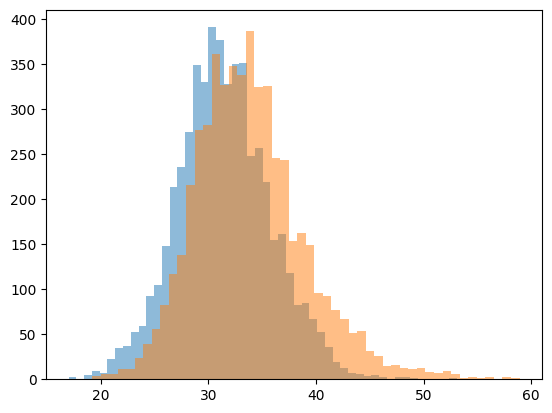

In [11]:
# Plot the distribtuion of X_zuigelingen_numericals['Leeftijd_moeder'] and X_zuigelingen_numericals['Leeftijd_ouder2'], excluding NaN values
plt.hist(X_zuigelingen_numericals['Leeftijd_moeder'].dropna(), bins=50, alpha=0.5, label='Leeftijd_moeder')
plt.hist(X_zuigelingen_numericals['Leeftijd_ouder2'].dropna(), bins=50, alpha=0.5, label='Leeftijd_ouder2')

# Print the min and max values of the age features
print(f"Min leeftijd moeder: {round(X_zuigelingen_numericals['Leeftijd_moeder'].min(),2)}, Max leeftijd moeder: {round(X_zuigelingen_numericals['Leeftijd_moeder'].max(),2)}")
print(f"Min leeftijd Ouder2: {round(X_zuigelingen_numericals['Leeftijd_ouder2'].min(),2)}, Max leeftijd Ouder2: {round(X_zuigelingen_numericals['Leeftijd_ouder2'].max(),2)}")

#### 3.2 Categorical features

In [12]:
# Get categorical columns
X_zuigelingen_categoricals = zuigelingen[[
    # 'Geboorteland',                       # Lies in CBS_indeling, too sparse
    # 'Geboorteland_relatie_ouder1',        # Lies in CBS_indeling, too sparse
    # 'Geboorteland_relatie_ouder2',        # Lies in CBS_indeling, too sparse
    # 'Geboorteland_cat',                   # Lies in CBS_indeling, too sparse
    # 'Geboorteland_relatie_ouder1_cat',    # Lies in CBS_indeling, too sparse
    # 'Geboorteland_relatie_ouder2_cat',    # Lies in CBS_indeling, too sparse
    # 'Geboorteland_cat3',                  # Lies in CBS_indeling, too sparse
    # 'Geboorteland_relatie_ouder1_cat3',   # Lies in CBS_indeling, too sparse
    # 'Geboorteland_relatie_ouder2_cat3',   # Lies in CBS_indeling, too sparse
    'percentage_geb_nederland_herkomst_nederland',                # Ordinal
    'percentage_geb_nederland_herkomst_overig_europa',            # Ordinal
    'percentage_geb_nederland_herkomst_buiten_europa',            # Ordinal
    'percentage_geb_buiten_nederland_herkomst_europa',            # Ordinal
    'percentage_geb_buiten_nederland_herkmst_buiten_europa',      # Ordinal
    'percentage_huurwoningen',                                    # Ordinal
    'stedelijkheid',                                              # Ordinal
    'CBS_indeling',
    'Toestemming'
    ]]

In [13]:
# Create dummy variables
X_zuigelingen_categoricals = pd.get_dummies(X_zuigelingen_categoricals, columns=X_zuigelingen_categoricals.columns, dummy_na=True, drop_first=False)

In [14]:
X_zuigelingen_categoricals

,percentage_geb_nederland_herkomst_nederland_70.0,percentage_geb_nederland_herkomst_nederland_80.0,percentage_geb_nederland_herkomst_nederland_90.0,percentage_geb_nederland_herkomst_nederland_100.0,percentage_geb_nederland_herkomst_nederland_nan,percentage_geb_nederland_herkomst_overig_europa_0.0,percentage_geb_nederland_herkomst_overig_europa_10.0,percentage_geb_nederland_herkomst_overig_europa_nan,percentage_geb_nederland_herkomst_buiten_europa_0.0,percentage_geb_nederland_herkomst_buiten_europa_10.0,...,stedelijkheid_4.0,stedelijkheid_5.0,stedelijkheid_nan,CBS_indeling_Kindmigrant,CBS_indeling_Migrant,CBS_indeling_Nederlands,CBS_indeling_nan,Toestemming_0.0,Toestemming_1.0,Toestemming_nan
0,False,False,True,False,False,True,False,False,True,False,...,True,False,False,False,False,True,False,False,True,False
1,True,False,False,False,False,True,False,False,False,True,...,False,False,False,False,False,True,False,False,True,False
2,False,False,True,False,False,True,False,False,True,False,...,False,True,False,False,False,True,False,False,False,True
3,False,True,False,False,False,True,False,False,False,True,...,False,False,False,False,False,True,False,False,True,False
4,False,True,False,False,False,True,False,False,False,True,...,False,False,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5379,False,False,True,False,False,True,False,False,True,False,...,False,False,False,False,False,True,False,False,True,False
5380,False,False,True,False,False,True,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False
5381,False,False,True,False,False,True,False,False,True,False,...,False,False,False,False,False,True,False,False,True,False
5382,False,True,False,False,False,True,False,False,False,True,...,False,False,False,False,False,True,False,False,True,False


#### 3.3 Boolean features

In [15]:
# Get boolean columns
X_zuigelingen_booleans = zuigelingen[[
    'Tweeling',
    'Geslacht',
    'Geslacht_relatie_ouder1',
    'Geslacht_relatie_ouder2',
    'Gevaccineerd_ouder1',
    'Gevaccineerd_ouder2'
    ]]

In [16]:
X_zuigelingen_booleans

,Tweeling,Geslacht,Geslacht_relatie_ouder1,Geslacht_relatie_ouder2,Gevaccineerd_ouder1,Gevaccineerd_ouder2
0,False,Mannelijk,vrouwelijk,mannelijk,True,True
1,False,Vrouwelijk,vrouwelijk,mannelijk,False,False
2,False,Mannelijk,vrouwelijk,mannelijk,False,False
3,False,Vrouwelijk,vrouwelijk,mannelijk,True,True
4,False,Mannelijk,vrouwelijk,mannelijk,True,True
...,...,...,...,...,...,...
5379,False,Vrouwelijk,NaN,NaN,True,True
5380,False,Mannelijk,NaN,NaN,True,NaN
5381,False,Vrouwelijk,NaN,NaN,True,True
5382,False,Mannelijk,vrouwelijk,mannelijk,NaN,NaN


In [17]:
# Specify boolean mapping
def boolean_mapper(df):
    bool_mapping = {'Ja': True, 'Nee': False,
                    'Vaccinated': True, 'Not Vaccinated': False,
                    'Mannelijk': True, 'Vrouwelijk': False,
                    'mannelijk': True, 'vrouwelijk': False,
                    1: True, 0: False}
    def convert_to_bool(column):
        return bool_mapping.get(column, np.NaN)

    for col in df.columns:
        df[col] = df[col].apply(convert_to_bool)
    return df

# Apply boolean mapping
boolean_mapper(X_zuigelingen_booleans)

,Tweeling,Geslacht,Geslacht_relatie_ouder1,Geslacht_relatie_ouder2,Gevaccineerd_ouder1,Gevaccineerd_ouder2
0,False,True,False,True,True,True
1,False,False,False,True,False,False
2,False,True,False,True,False,False
3,False,False,False,True,True,True
4,False,True,False,True,True,True
...,...,...,...,...,...,...
5379,False,False,NaN,NaN,True,True
5380,False,True,NaN,NaN,True,NaN
5381,False,False,NaN,NaN,True,True
5382,False,True,False,True,NaN,NaN


In [18]:
# Change column names
X_zuigelingen_booleans.columns = X_zuigelingen_booleans.columns.str.replace('Geslacht', 'Geslacht=mannelijk')

In [19]:
# Save all one-hot coded column names
one_hot_columns = list(X_zuigelingen_categoricals.columns) + list(X_zuigelingen_booleans.columns)

#### 3.4 Target feature

In [20]:
# Store the target variable
y_zuigelingen = zuigelingen['Zuigelingen_status']

In [21]:
# Get 'Zuigelingen_status' for every row where it is 'Partially vaccinated' or 'Not Vaccinated'
y_zuigelingen_not_part = zuigelingen[(zuigelingen['Zuigelingen_status'] == 'Partially vaccinated') | (zuigelingen['Zuigelingen_status'] == 'Not Vaccinated')]['Zuigelingen_status']

In [22]:
# Specify mappings
target_mapping = {'Not Vaccinated': 0,
                  'Partially vaccinated': 1,
                  'Vaccinated': 2}

# Apply the mapping to the Series
y_zuigelingen = y_zuigelingen.map(target_mapping)
y_zuigelingen_not_part = y_zuigelingen_not_part.map(target_mapping)

In [23]:
# Count unique values of y_zuigelingen
np.unique(y_zuigelingen, return_counts=True)

(array([0, 1, 2], dtype=int64), array([ 218,  267, 4899], dtype=int64))

In [24]:
# Count unique values of y_zuigelingen
np.unique(y_zuigelingen_not_part, return_counts=True)

(array([0, 1], dtype=int64), array([218, 267], dtype=int64))

### 4. Feature selection

In [25]:
# Print the percentage of missing values per column
print(f'The percentage of missing values per column is:')
for col in X_zuigelingen_numericals.columns:
    print(f'{col:<100}: {round(X_zuigelingen_numericals[col].isnull().mean(), 2)}')

The percentage of missing values per column is:
BMR                                                                                                 : 0.0
DKTP                                                                                                : 0.0
DTP                                                                                                 : 0.0
Hib                                                                                                 : 0.0
Pneu                                                                                                : 0.0
Excluded                                                                                            : 0.0
Hepatitis_B                                                                                         : 0.0
MenACWYMenC                                                                                         : 0.0
gemiddelde_woz_waarde_woning                                                                        : 0.

In [26]:
# Print the percentage of missing values per column
print(f'The percentage of missing values per column is:')
for col in X_zuigelingen_categoricals.columns:
    print(f'{col:<100}: {round(X_zuigelingen_categoricals[col].isnull().mean(), 2)}')

The percentage of missing values per column is:
percentage_geb_nederland_herkomst_nederland_70.0                                                    : 0.0
percentage_geb_nederland_herkomst_nederland_80.0                                                    : 0.0
percentage_geb_nederland_herkomst_nederland_90.0                                                    : 0.0
percentage_geb_nederland_herkomst_nederland_100.0                                                   : 0.0
percentage_geb_nederland_herkomst_nederland_nan                                                     : 0.0
percentage_geb_nederland_herkomst_overig_europa_0.0                                                 : 0.0
percentage_geb_nederland_herkomst_overig_europa_10.0                                                : 0.0
percentage_geb_nederland_herkomst_overig_europa_nan                                                 : 0.0
percentage_geb_nederland_herkomst_buiten_europa_0.0                                                 : 0.

In [27]:
# Print the percentage of missing values per column
print(f'The percentage of missing values per column is:')
for col in X_zuigelingen_booleans.columns:
    print(f'{col:<100}: {round(X_zuigelingen_booleans[col].isnull().mean(), 2)}')

The percentage of missing values per column is:
Tweeling                                                                                            : 0.0
Geslacht=mannelijk                                                                                  : 0.0
Geslacht=mannelijk_relatie_ouder1                                                                   : 0.17
Geslacht=mannelijk_relatie_ouder2                                                                   : 0.19
Gevaccineerd_ouder1                                                                                 : 0.1
Gevaccineerd_ouder2                                                                                 : 0.11


### 5. Merge and drop features

In [28]:
# Merge all dataframes
X_zuigelingen = pd.concat([X_zuigelingen_numericals, X_zuigelingen_categoricals, X_zuigelingen_booleans], axis=1)

# Drop sex columns from booleans, as they have large amounts of missing values and were mostly important for their vaccination statuses
X_zuigelingen = X_zuigelingen.drop(columns=['Geslacht=mannelijk_relatie_ouder1', 'Geslacht=mannelijk_relatie_ouder2'])

### 6. Split subsets

In [29]:
# Split subset of X_zuigelingen_numericals
X_zuigelingen_notvaccinated = X_zuigelingen[y_zuigelingen == 0]
X_zuigelingen_partiallyvaccinated = X_zuigelingen[y_zuigelingen == 1]

# Make copy of X_zuigelingen
X_zuigelingen_reduced = X_zuigelingen.copy()

# Delete columns from X_zuigelingen that have >50% missings in X_zuigelingen_notvaccinated
for col in X_zuigelingen.columns:
    if col in X_zuigelingen_notvaccinated.columns:
        if X_zuigelingen_notvaccinated[col].isnull().mean() > 0.5 or X_zuigelingen_partiallyvaccinated[col].isnull().mean() > 0.5:
            X_zuigelingen_reduced = X_zuigelingen_reduced.drop(columns=col)

# Make list of strings with column names in X_zuigelingen containing 'nan'
nan_columns = [col for col in X_zuigelingen.columns if 'nan' in col]

# Loop over nan_columns in X_zuigelingen_reduced and calculate if >50% is 'True'
for col in nan_columns:
    col_variable = col.split('_nan')[0]
    if col_variable != 'Toestemming':
        if (1- X_zuigelingen_notvaccinated[col].value_counts(normalize=True)[False]) > 0.5:
            X_zuigelingen_reduced = X_zuigelingen_reduced.drop(columns=[col for col in X_zuigelingen_reduced.columns if col_variable in col])

# Show which columns got dropped
print(f'The columns that were dropped from X_zuigelingen are:')
for col in X_zuigelingen.columns:
    if col not in X_zuigelingen_reduced.columns:
        print(f'    {col}')

The columns that were dropped from X_zuigelingen are:
    InkomenInkomen_van_personenGemiddeld_inkomen_per_inkomensontvanger_x_1_000_euro
    InkomenInkomen_van_personenGemiddeld_inkomen_per_inwoner_x_1_000_euro
    InkomenInkomen_van_huishoudensGem_gestandaardiseerd_inkomen_van_huish_x_1_000_euro


In [30]:
# Randomly sample 10% of the data
if TEST_instances:
    X_zuigelingen_reduced = X_zuigelingen_reduced.sample(frac=0.1, random_state=42)
    y_zuigelingen = y_zuigelingen.loc[X_zuigelingen_reduced.index]

### 7. Missing value imputation

In [31]:
# Initialize the IterativeImputer
if TEST_iterations:
    imputer = IterativeImputer(random_state=42, estimator=RandomForestRegressor(random_state=42), max_iter=3)
else:
    imputer = IterativeImputer(random_state=42, estimator=RandomForestRegressor(random_state=42), max_iter=5)

In [32]:
# Print the percentages of missing values per column
print(f'The percentage of missing values per column is:')
for col in X_zuigelingen_reduced.columns:
    print(f'{col:<100}: {round(X_zuigelingen_reduced[col].isnull().mean(), 2)}')

The percentage of missing values per column is:
BMR                                                                                                 : 0.0
DKTP                                                                                                : 0.0
DTP                                                                                                 : 0.0
Hib                                                                                                 : 0.0
Pneu                                                                                                : 0.0
Excluded                                                                                            : 0.0
Hepatitis_B                                                                                         : 0.0
MenACWYMenC                                                                                         : 0.0
gemiddelde_woz_waarde_woning                                                                        : 0.

In [33]:
# Fit the imputer on the data
imputer.fit(X_zuigelingen_reduced)

# Transform the data
X_zuigelingen_imputed = pd.DataFrame(imputer.transform(X_zuigelingen_reduced), columns=X_zuigelingen_reduced.columns)

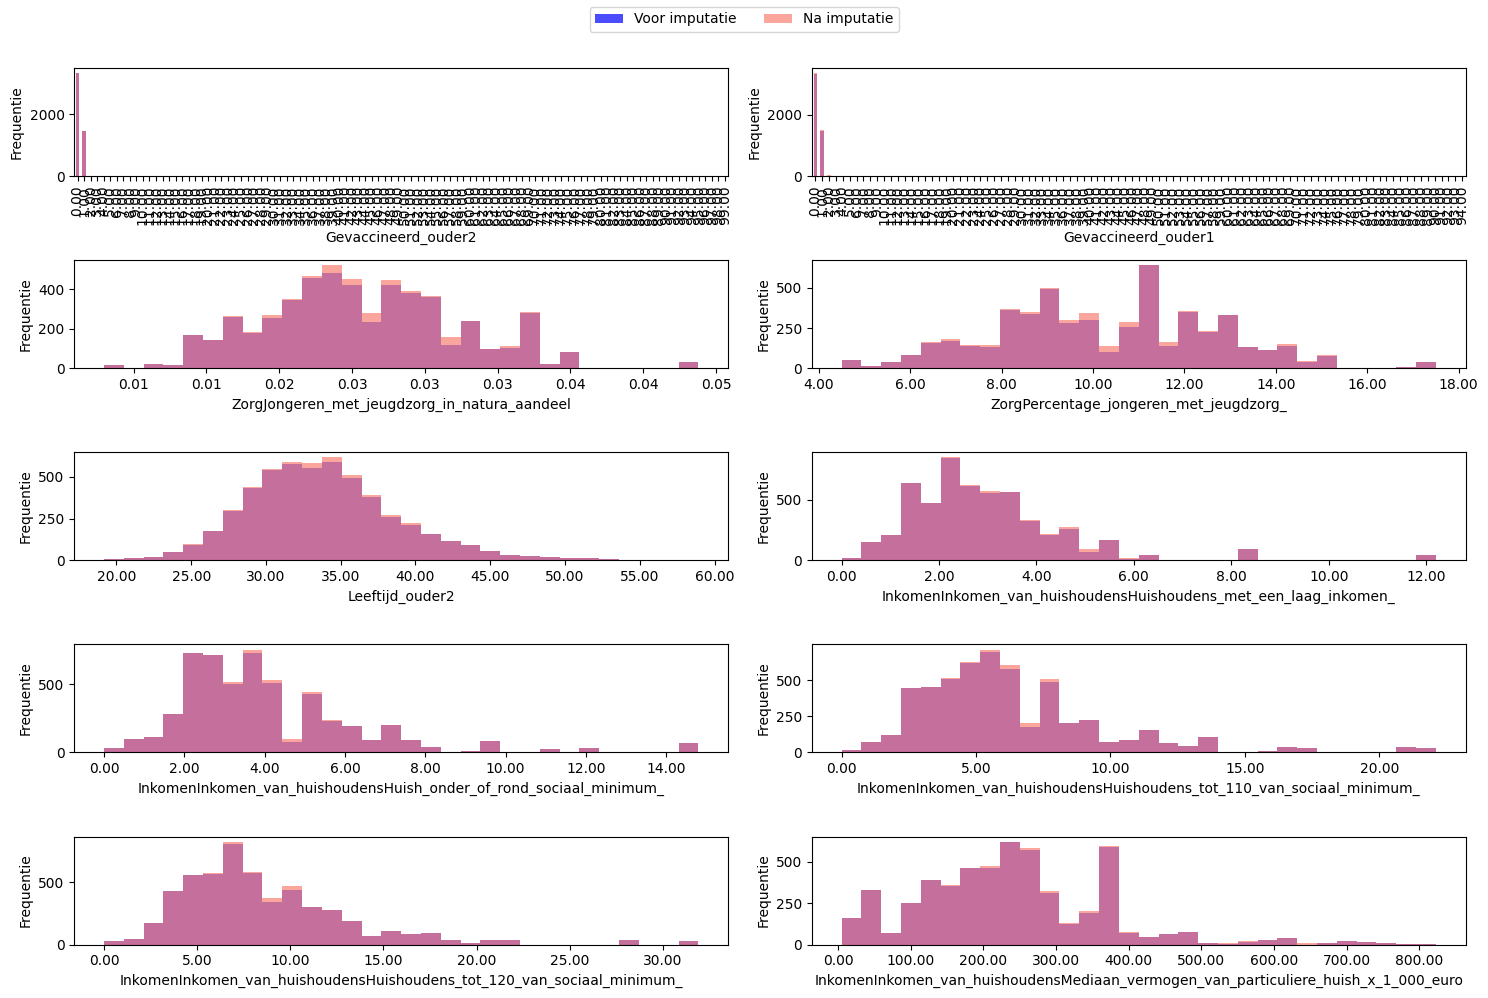

In [34]:
# Get the top 10 missing value columns
missing_values = X_zuigelingen_reduced.isnull().sum().sort_values(ascending=False).head(10).index

# Create a 5x2 subplot frame
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Define custom colors
color_before = 'blue'
color_after = 'salmon'

# Define a formatter function to round to two decimals
formatter = FuncFormatter(lambda x, _: f'{x:.2f}')

# Plot the histograms and bar charts
for i, column in enumerate(missing_values):
    if X_zuigelingen_reduced[column].dtype == 'float64':
        X_zuigelingen_reduced[column].plot.hist(ax=axes[i], bins=30, alpha=0.7, label='Voor imputatie', color=color_before)
        X_zuigelingen_imputed[column].plot.hist(ax=axes[i], bins=30, alpha=0.7, label='Na imputatie', color=color_after)
    else:
        X_zuigelingen_reduced[column].value_counts().plot.bar(ax=axes[i], alpha=0.7, label='Voor imputatie', color=color_before)
        X_zuigelingen_imputed[column].value_counts().plot.bar(ax=axes[i], alpha=0.7, label='Na imputatie', color=color_after)
    
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequentie')
    axes[i].xaxis.set_major_formatter(formatter) 

# Collect handles and labels from the first subplot
handles, labels = axes[0].get_legend_handles_labels()

# Create a single legend for the entire figure
fig.legend(handles, labels, loc='upper center', ncol=2)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust rect to make space for the legend
plt.show()

### 8. Drop features related to target

In [35]:
# List of columns to drop
columns_to_drop = ['BMR', 'DKTP', 'DTP', 'Hib', 'Pneu', 'Excluded', 'Hepatitis_B', 'MenACWYMenC']

# Filter out columns that are not in the DataFrame
columns_to_drop = [col for col in columns_to_drop if col in X_zuigelingen_imputed.columns]

# Drop the specified columns from the DataFrames
X_zuigelingen = X_zuigelingen_imputed.drop(columns=columns_to_drop)

### 9. Round boolean columns to 0 or 1

In [36]:
# Round values within 'bools' columns to 0 or 1 if they exist
for col in one_hot_columns:
    if col in X_zuigelingen.columns:
        X_zuigelingen[col] = X_zuigelingen[col].round().astype(bool)

### 10. Save .pkl's

In [37]:
# Save original features
X_zuigelingen.to_pickle('4_Data/Pickles/X_zuigelingen.pkl')

# Save subs
X_zuigelingen_notvaccinated = X_zuigelingen.loc[y_zuigelingen == 0]
X_zuigelingen_partiallyvaccinated = X_zuigelingen.loc[y_zuigelingen == 1]
X_zuigelingen_vaccinated = X_zuigelingen.loc[y_zuigelingen == 2]

# Save
X_zuigelingen_notvaccinated.to_pickle('4_Data/Pickles/X_zuigelingen_notvaccinated.pkl')
X_zuigelingen_partiallyvaccinated.to_pickle('4_Data/Pickles/X_zuigelingen_partiallyvaccinated.pkl')
X_zuigelingen_vaccinated.to_pickle('4_Data/Pickles/X_zuigelingen_vaccinated.pkl')

In [38]:
# Save scaler for numerical subsets
scaler = RobustScaler()

# Save y_zuigelingen
np.save('4_Data\Arrays\y_zuigelingen.npy', y_zuigelingen)

# Save columns of dtype float of X_zuigelingen
X_zuigelingen_notvaccinated_numericals = X_zuigelingen_notvaccinated.select_dtypes(include='float64')
X_zuigelingen_notvaccinated_numericals = pd.DataFrame(scaler.fit_transform(X_zuigelingen_notvaccinated_numericals), columns=X_zuigelingen_notvaccinated_numericals.columns)
X_zuigelingen_notvaccinated_numericals.to_pickle('4_Data/Pickles/X_zuigelingen_notvaccinated_numericals.pkl')

X_zuigelingen_partiallyvaccinated_numericals = X_zuigelingen_partiallyvaccinated.select_dtypes(include='float64')
X_zuigelingen_partiallyvaccinated_numericals = pd.DataFrame(scaler.transform(X_zuigelingen_partiallyvaccinated_numericals), columns=X_zuigelingen_partiallyvaccinated_numericals.columns)
X_zuigelingen_partiallyvaccinated_numericals.to_pickle('4_Data/Pickles/X_zuigelingen_partiallyvaccinated_numericals.pkl')

# Save columns of dtype bool of X_zuigelingen
X_zuigelingen_notvaccinated_booleans = X_zuigelingen_notvaccinated.select_dtypes(exclude='float64')
X_zuigelingen_notvaccinated_booleans.to_pickle('4_Data/Pickles/X_zuigelingen_notvaccinated_booleans.pkl')

X_zuigelingen_partiallyvaccinated_booleans = X_zuigelingen_partiallyvaccinated.select_dtypes(exclude='float64')
X_zuigelingen_partiallyvaccinated_booleans.to_pickle('4_Data/Pickles/X_zuigelingen_partiallyvaccinated_booleans.pkl')